# Dataset Validation and Baseline Model Training
## Validate the clean feature extraction pipeline with 2-patient dataset
### Goals: Check data quality, train baseline model, analyze feature importance

In [1]:
# Cell 1: Imports and Setup
print("--- Loading libraries for dataset validation... ---")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")

--- Loading libraries for dataset validation... ---
✅ Libraries loaded successfully!


In [2]:
# Cell 2: Load and Inspect Dataset
print("--- Loading and inspecting dataset... ---")

# Load the dataset
CSV_PATH = '../data/datasets/clean_features_dataset.csv'  # Update path as needed
try:
    df = pd.read_csv(CSV_PATH)
    print(f"✅ Dataset loaded successfully!")
except FileNotFoundError:
    print(f"❌ File not found: {CSV_PATH}")
    print("Please update CSV_PATH to the correct location of your dataset.")
    df = None

if df is not None:
    # Basic dataset info
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"{'='*50}")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print(f"Patients: {df['patient_id'].nunique()}")
    print(f"Patient IDs: {list(df['patient_id'].unique())}")
    
    # Check for missing values
    missing_counts = df.isnull().sum()
    if missing_counts.sum() > 0:
        print(f"\n⚠️  Missing values found:")
        print(missing_counts[missing_counts > 0])
    else:
        print(f"\n✅ No missing values detected")
    
    # Display first few rows
    print(f"\n📋 FIRST 5 ROWS:")
    display(df.head())
    
    # Display data types
    print(f"\n🔍 DATA TYPES:")
    print(df.dtypes)

--- Loading and inspecting dataset... ---
✅ Dataset loaded successfully!

📊 DATASET OVERVIEW:
Shape: (30763, 21)
Memory usage: 6.4 MB
Patients: 2
Patient IDs: ['patient_01', 'patient_02']

✅ No missing values detected

📋 FIRST 5 ROWS:


,patient_id,timestamp,apnea_label,clean_rms,clean_zcr,clean_centroid,clean_mfcc_1,clean_mfcc_2,clean_mfcc_3,clean_mfcc_4,clean_mfcc_5,clean_mfcc_6,clean_mfcc_7,clean_mfcc_8,clean_mfcc_9,clean_mfcc_10,clean_mfcc_11,clean_mfcc_12,clean_mfcc_13,clean_bandwidth,clean_rolloff
0,patient_01,0.0,0,0.002957,0.038013,5184.379121,-572.511686,77.634704,25.523233,22.377389,18.282672,16.448310,13.735450,9.276120,11.262300,9.085844,11.751019,6.624314,5.371012,7052.165879,14297.373670
1,patient_01,1.0,0,0.002647,0.038273,5439.932125,-576.898427,76.954070,31.757845,25.229073,17.300561,16.035077,13.461015,10.200860,11.664093,8.736473,9.953292,5.553295,6.115852,7196.782201,14961.851729
2,patient_01,2.0,0,0.002572,0.035468,5429.548998,-578.677383,77.234862,33.943633,26.847105,16.748511,13.001820,10.351312,7.976148,10.951830,9.721292,12.202796,7.371331,8.676530,7222.871501,15047.373670
3,patient_01,3.0,0,0.002537,0.040720,5594.177052,-576.022008,75.372162,30.832696,26.665834,16.181666,14.671672,12.862543,8.328607,10.373918,9.028210,11.446785,6.953613,9.544548,7200.408965,15042.137633
4,patient_01,4.0,0,0.002737,0.030736,5461.627288,-580.093610,75.355579,32.424951,24.865797,16.393537,15.029441,11.681507,8.188858,11.099735,8.870686,10.977174,6.693128,8.106464,7240.047128,15091.007314



🔍 DATA TYPES:
patient_id          object
timestamp          float64
apnea_label          int64
clean_rms          float64
clean_zcr          float64
clean_centroid     float64
clean_mfcc_1       float64
clean_mfcc_2       float64
clean_mfcc_3       float64
clean_mfcc_4       float64
clean_mfcc_5       float64
clean_mfcc_6       float64
clean_mfcc_7       float64
clean_mfcc_8       float64
clean_mfcc_9       float64
clean_mfcc_10      float64
clean_mfcc_11      float64
clean_mfcc_12      float64
clean_mfcc_13      float64
clean_bandwidth    float64
clean_rolloff      float64
dtype: object


--- Analyzing class balance and patient distribution... ---

📊 OVERALL CLASS DISTRIBUTION:
Total frames: 30,763
Apnea frames: 2,608 (8.48%)
Normal frames: 28,155 (91.52%)
✅ Apnea rate seems reasonable for sleep studies

👥 PER-PATIENT ANALYSIS:
patient_01:
  📊 14,900 frames (1.0 hours)
  🚨 1,527 apnea events (10.25%)
  😴 13,373 normal frames (89.75%)
patient_02:
  📊 15,863 frames (1.0 hours)
  🚨 1,081 apnea events (6.81%)
  😴 14,782 normal frames (93.19%)


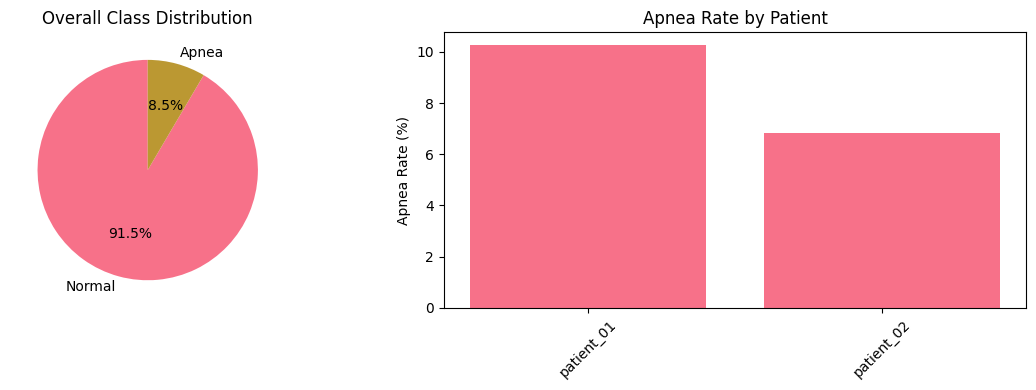

In [3]:
# Cell 3: Class Balance Analysis
print("--- Analyzing class balance and patient distribution... ---")

if df is not None:
    # Overall class distribution
    apnea_count = df['apnea_label'].sum()
    total_count = len(df)
    apnea_percentage = (apnea_count / total_count) * 100
    
    print(f"\n📊 OVERALL CLASS DISTRIBUTION:")
    print(f"{'='*50}")
    print(f"Total frames: {total_count:,}")
    print(f"Apnea frames: {apnea_count:,} ({apnea_percentage:.2f}%)")
    print(f"Normal frames: {total_count - apnea_count:,} ({100 - apnea_percentage:.2f}%)")
    
    if apnea_percentage < 1:
        print(f"⚠️  Very low apnea rate - may need class balancing strategies")
    elif apnea_percentage > 20:
        print(f"⚠️  High apnea rate - please verify data quality")
    else:
        print(f"✅ Apnea rate seems reasonable for sleep studies")
    
    # Per-patient analysis
    print(f"\n👥 PER-PATIENT ANALYSIS:")
    print(f"{'='*50}")
    patient_stats = df.groupby('patient_id').agg({
        'apnea_label': ['count', 'sum', 'mean'],
        'timestamp': ['min', 'max']
    })
    
    for patient in patient_stats.index:
        frame_count = patient_stats.loc[patient, ('apnea_label', 'count')]
        apnea_frames = patient_stats.loc[patient, ('apnea_label', 'sum')]
        apnea_rate = patient_stats.loc[patient, ('apnea_label', 'mean')] * 100
        duration_hours = (patient_stats.loc[patient, ('timestamp', 'max')] - 
                         patient_stats.loc[patient, ('timestamp', 'min')]) / 3600
        
        print(f"{patient}:")
        print(f"  📊 {frame_count:,} frames ({duration_hours:.1f} hours)")
        print(f"  🚨 {apnea_frames:,} apnea events ({apnea_rate:.2f}%)")
        print(f"  😴 {frame_count - apnea_frames:,} normal frames ({100-apnea_rate:.2f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Overall class distribution
    class_counts = df['apnea_label'].value_counts()
    axes[0].pie(class_counts.values, labels=['Normal', 'Apnea'], autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Overall Class Distribution')
    
    # Per-patient apnea rates
    patient_apnea_rates = df.groupby('patient_id')['apnea_label'].mean() * 100
    axes[1].bar(patient_apnea_rates.index, patient_apnea_rates.values)
    axes[1].set_title('Apnea Rate by Patient')
    axes[1].set_ylabel('Apnea Rate (%)')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

--- Analyzing features and data quality... ---

🎯 FEATURE ANALYSIS:
Total columns: 21
Feature columns: 18
Metadata columns: 3

Feature columns: ['clean_rms', 'clean_zcr', 'clean_centroid', 'clean_mfcc_1', 'clean_mfcc_2', 'clean_mfcc_3', 'clean_mfcc_4', 'clean_mfcc_5', 'clean_mfcc_6', 'clean_mfcc_7', 'clean_mfcc_8', 'clean_mfcc_9', 'clean_mfcc_10', 'clean_mfcc_11', 'clean_mfcc_12', 'clean_mfcc_13', 'clean_bandwidth', 'clean_rolloff']

📊 FEATURE STATISTICS:


,clean_rms,clean_zcr,clean_centroid,clean_mfcc_1,clean_mfcc_2,clean_mfcc_3,clean_mfcc_4,clean_mfcc_5,clean_mfcc_6,clean_mfcc_7,clean_mfcc_8,clean_mfcc_9,clean_mfcc_10,clean_mfcc_11,clean_mfcc_12,clean_mfcc_13,clean_bandwidth,clean_rolloff
count,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000,30763.000000
mean,0.007478,0.025559,3864.635283,-545.536602,96.147098,27.781942,29.765517,14.850329,15.567338,10.616213,10.341224,7.391239,6.701757,8.091421,6.186081,7.172685,5865.937888,10005.964374
std,0.006958,0.017437,1583.460216,69.706754,25.519866,13.522019,7.312359,5.761483,4.732988,4.374500,4.031717,3.375736,3.065365,4.533911,3.679024,3.597741,1313.707333,4836.249518
min,0.000015,0.000000,81.810739,-1126.542337,6.659716,-34.705875,-0.081408,-20.886064,-8.424396,-14.119367,-19.619777,-14.039172,-17.634770,-15.824172,-14.936275,-14.087906,183.479665,171.293218
25%,0.003079,0.013672,2885.802802,-572.938062,73.344375,21.807620,24.553322,10.501636,13.630533,7.171130,8.201677,5.599675,5.032346,4.245048,4.610704,5.787523,5264.716633,7490.275931
50%,0.004858,0.022248,3533.417235,-554.494851,100.316219,30.384245,30.062286,14.606807,15.377975,10.478667,9.667036,7.484774,6.343388,8.457135,5.800644,7.665216,5691.477562,9111.951463
75%,0.006411,0.035619,5307.275368,-526.784537,112.884917,37.908236,35.103054,19.315530,17.045105,14.180049,11.445318,9.492373,8.371156,10.436768,7.615890,9.359281,7070.794668,14561.419548
max,0.065026,0.206174,10563.105836,-238.669778,169.490453,53.355672,67.084077,42.999961,42.642237,29.812037,37.056158,25.995554,24.706244,33.356830,25.372678,23.836275,7753.611008,19447.888963



🔍 FEATURE QUALITY CHECKS:
✅ No zero variance features
✅ No extremely low variance features
✅ No infinite or extreme values detected

🔥 FEATURE CORRELATION ANALYSIS:
Showing correlation for first 10 features: ['clean_rms', 'clean_zcr', 'clean_centroid', 'clean_mfcc_1', 'clean_mfcc_2', 'clean_mfcc_3', 'clean_mfcc_4', 'clean_mfcc_5', 'clean_mfcc_6', 'clean_mfcc_7']


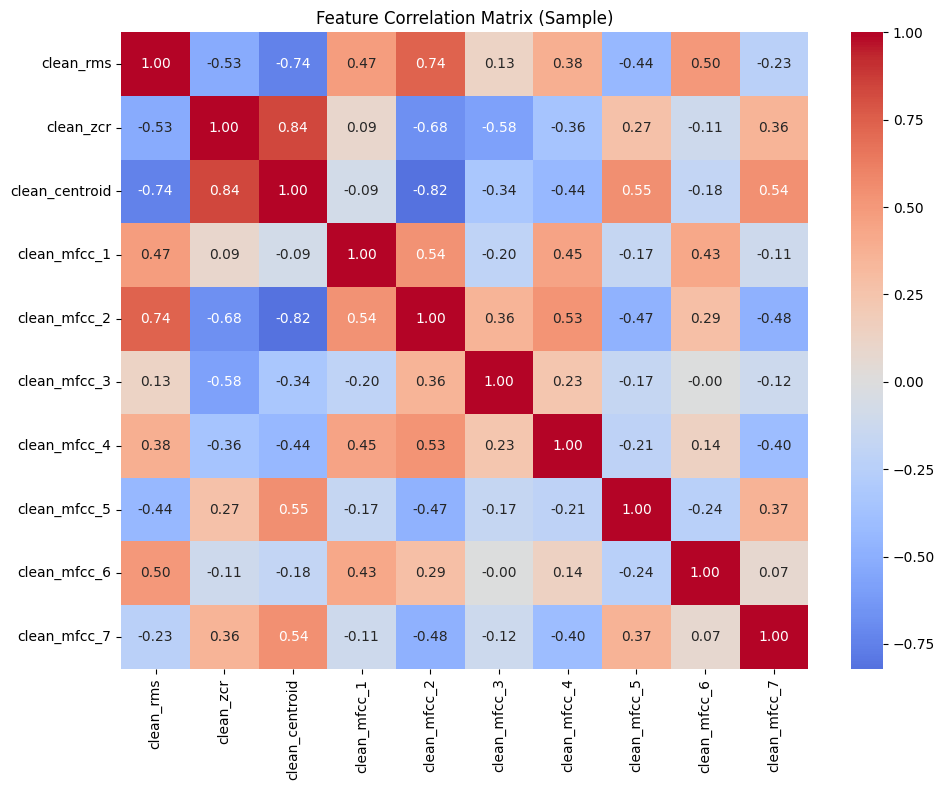


✅ No extremely high correlations detected


In [4]:
# Cell 4: Feature Analysis and Data Quality
print("--- Analyzing features and data quality... ---")

if df is not None:
    # Identify feature columns (exclude metadata)
    feature_cols = [col for col in df.columns if col.startswith('clean_')]
    metadata_cols = ['patient_id', 'timestamp', 'apnea_label']
    
    print(f"\n🎯 FEATURE ANALYSIS:")
    print(f"{'='*50}")
    print(f"Total columns: {len(df.columns)}")
    print(f"Feature columns: {len(feature_cols)}")
    print(f"Metadata columns: {len(metadata_cols)}")
    print(f"\nFeature columns: {feature_cols}")
    
    # Feature statistics
    X = df[feature_cols]
    
    print(f"\n📊 FEATURE STATISTICS:")
    feature_stats = X.describe()
    display(feature_stats)
    
    # Check for constant or near-constant features
    print(f"\n🔍 FEATURE QUALITY CHECKS:")
    print(f"{'='*50}")
    
    # Features with zero variance
    zero_var_features = feature_stats.columns[feature_stats.loc['std'] == 0]
    if len(zero_var_features) > 0:
        print(f"⚠️  Zero variance features: {list(zero_var_features)}")
    else:
        print(f"✅ No zero variance features")
    
    # Features with very low variance (std < 1e-6)
    low_var_features = feature_stats.columns[feature_stats.loc['std'] < 1e-6]
    if len(low_var_features) > 0:
        print(f"⚠️  Very low variance features: {list(low_var_features)}")
    else:
        print(f"✅ No extremely low variance features")
    
    # Check for infinite or extremely large values
    inf_features = []
    for col in feature_cols:
        if np.isinf(X[col]).any() or (np.abs(X[col]) > 1e10).any():
            inf_features.append(col)
    
    if inf_features:
        print(f"⚠️  Features with infinite/extreme values: {inf_features}")
    else:
        print(f"✅ No infinite or extreme values detected")
    
    # Feature correlation heatmap (sample of features if too many)
    print(f"\n🔥 FEATURE CORRELATION ANALYSIS:")
    if len(feature_cols) > 10:
        # Show correlation for first 10 features
        sample_features = feature_cols[:10]
        print(f"Showing correlation for first 10 features: {sample_features}")
    else:
        sample_features = feature_cols
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = X[sample_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlation Matrix (Sample)')
    plt.tight_layout()
    plt.show()
    
    # Highly correlated feature pairs
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.9:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    correlation_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print(f"\n⚠️  Highly correlated feature pairs (|r| > 0.9):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"   {feat1} <-> {feat2}: {corr:.3f}")
    else:
        print(f"\n✅ No extremely high correlations detected")

--- Training baseline Random Forest model... ---

🎯 MODEL TRAINING SETUP:
Features shape: (30763, 18)
Target shape: (30763,)
Positive class ratio: 0.0848

Train set: 24,610 samples
Test set: 6,153 samples
Train apnea rate: 0.0848
Test apnea rate: 0.0848

🌲 TRAINING RANDOM FOREST:
Training model...
✅ Model trained successfully!

📊 MODEL PERFORMANCE:
F1 Score: 0.2428
AUC-ROC: 0.7078

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.93      0.88      0.90      5631
       Apnea       0.19      0.32      0.24       522

    accuracy                           0.83      6153
   macro avg       0.56      0.60      0.57      6153
weighted avg       0.87      0.83      0.85      6153



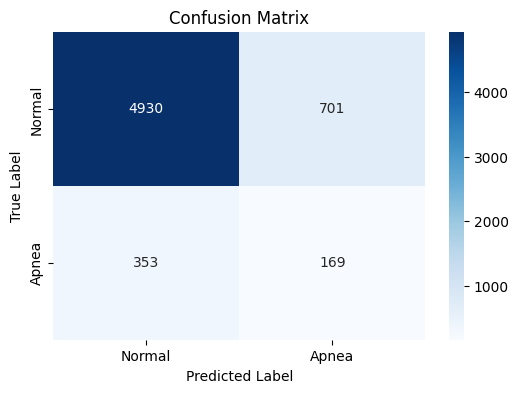


🔄 CROSS-VALIDATION:
Note: Limited generalizability with only 2 patients
CV F1 Scores: [0.1292868  0.08256589 0.0261379  0.0037037  0.        ]
CV F1 Mean: 0.0483 (+/- 0.1002)


In [5]:
# Cell 5: Baseline Model Training
print("--- Training baseline Random Forest model... ---")

if df is not None:
    # Prepare data
    X = df[feature_cols].copy()
    y = df['apnea_label'].copy()
    
    print(f"\n🎯 MODEL TRAINING SETUP:")
    print(f"{'='*50}")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Positive class ratio: {y.mean():.4f}")
    
    # Handle any remaining data quality issues
    # Replace infinite values with NaN, then fill with median
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    
    # Split data (simple random split since we only have 2 patients)
    # Note: This is not ideal for generalization but OK for validation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTrain set: {X_train.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")
    print(f"Train apnea rate: {y_train.mean():.4f}")
    print(f"Test apnea rate: {y_test.mean():.4f}")
    
    # Train Random Forest with class balancing
    print(f"\n🌲 TRAINING RANDOM FOREST:")
    print(f"{'='*50}")
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        n_jobs=-1
    )
    
    print("Training model...")
    rf_model.fit(X_train, y_train)
    print("✅ Model trained successfully!")
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n📊 MODEL PERFORMANCE:")
    print(f"{'='*50}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    # Detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Apnea']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Apnea'], 
                yticklabels=['Normal', 'Apnea'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Cross-validation (limited with only 2 patients, but still useful)
    print(f"\n🔄 CROSS-VALIDATION:")
    print(f"{'='*50}")
    print("Note: Limited generalizability with only 2 patients")
    
    cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='f1')
    print(f"CV F1 Scores: {cv_scores}")
    print(f"CV F1 Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

--- Analyzing feature importance... ---

🎯 FEATURE IMPORTANCE RANKING:
Top 10 most important features:
clean_mfcc_13             0.085357
clean_mfcc_8              0.081867
clean_mfcc_11             0.080176
clean_mfcc_7              0.064522
clean_mfcc_10             0.059547
clean_mfcc_2              0.055172
clean_mfcc_3              0.054649
clean_mfcc_5              0.053187
clean_mfcc_12             0.052114
clean_mfcc_4              0.051305


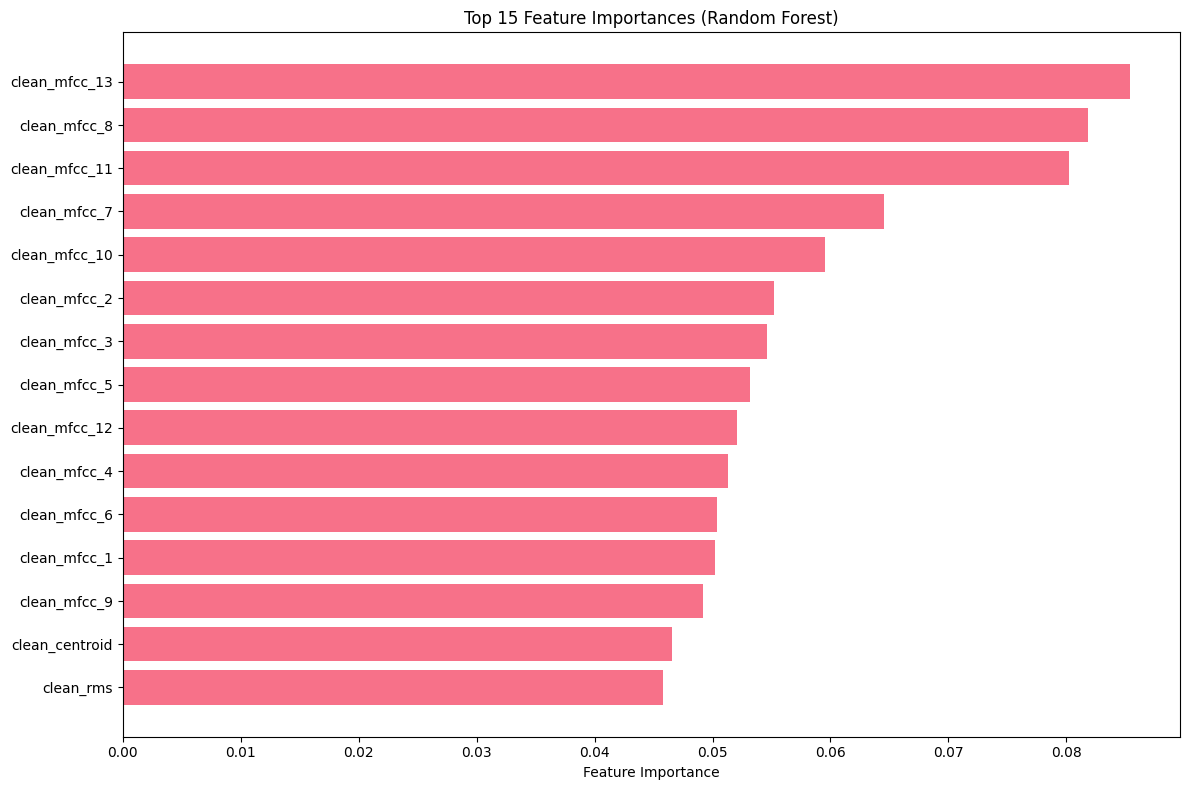


🔍 FEATURE TYPE ANALYSIS:
MFCC features total importance: 0.7876
Spectral features total importance: 0.1272
Energy features total importance: 0.0852


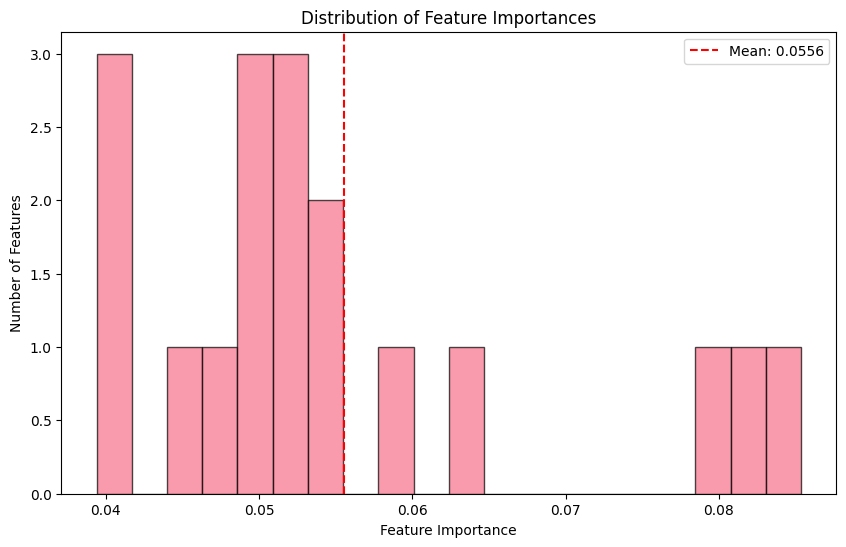


💡 FEATURE SELECTION RECOMMENDATIONS:
Features above average importance: 5 out of 18
Top 50% features capture 58.7% of total importance
⚠️  May need most features - importance is well distributed


In [6]:
# Cell 6: Feature Importance Analysis
print("--- Analyzing feature importance... ---")

if df is not None and 'rf_model' in locals():
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🎯 FEATURE IMPORTANCE RANKING:")
    print(f"{'='*50}")
    
    # Display top 10 features
    top_features = feature_importance.head(10)
    print("Top 10 most important features:")
    for idx, row in top_features.iterrows():
        print(f"{row['feature']:25} {row['importance']:.6f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    
    # Top 15 features
    top_15 = feature_importance.head(15)
    plt.barh(range(len(top_15)), top_15['importance'])
    plt.yticks(range(len(top_15)), top_15['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Analyze feature types
    print(f"\n🔍 FEATURE TYPE ANALYSIS:")
    print(f"{'='*50}")
    
    # Group by feature type
    mfcc_importance = feature_importance[feature_importance['feature'].str.contains('mfcc')]['importance'].sum()
    spectral_importance = feature_importance[feature_importance['feature'].str.contains('centroid|bandwidth|rolloff')]['importance'].sum()
    energy_importance = feature_importance[feature_importance['feature'].str.contains('rms|zcr')]['importance'].sum()
    
    print(f"MFCC features total importance: {mfcc_importance:.4f}")
    print(f"Spectral features total importance: {spectral_importance:.4f}")
    print(f"Energy features total importance: {energy_importance:.4f}")
    
    # Feature importance distribution
    plt.figure(figsize=(10, 6))
    plt.hist(feature_importance['importance'], bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Feature Importance')
    plt.ylabel('Number of Features')
    plt.title('Distribution of Feature Importances')
    plt.axvline(feature_importance['importance'].mean(), color='red', linestyle='--', 
                label=f'Mean: {feature_importance["importance"].mean():.4f}')
    plt.legend()
    plt.show()
    
    # Recommendations
    print(f"\n💡 FEATURE SELECTION RECOMMENDATIONS:")
    print(f"{'='*50}")
    
    # Features with importance > mean
    important_features = feature_importance[feature_importance['importance'] > feature_importance['importance'].mean()]
    print(f"Features above average importance: {len(important_features)} out of {len(feature_cols)}")
    
    # Top 50% of features
    top_50_percent = feature_importance.head(len(feature_cols)//2)
    print(f"Top 50% features capture {top_50_percent['importance'].sum():.1%} of total importance")
    
    if top_50_percent['importance'].sum() > 0.8:
        print(f"✅ Consider using only top {len(top_50_percent)} features for efficiency")
    else:
        print(f"⚠️  May need most features - importance is well distributed")

In [7]:
# Cell 7: Dataset Validation Summary and Recommendations
print("--- Dataset validation summary and recommendations... ---")

if df is not None:
    print(f"\n🎯 DATASET VALIDATION SUMMARY:")
    print(f"{'='*60}")
    
    # Data quality assessment
    data_quality_score = 0
    
    print(f"\n📊 DATA QUALITY ASSESSMENT:")
    print(f"{'-'*40}")
    
    # Check 1: No missing values
    if df.isnull().sum().sum() == 0:
        print(f"✅ No missing values")
        data_quality_score += 1
    else:
        print(f"⚠️  Has missing values")
    
    # Check 2: Reasonable class balance
    apnea_rate = df['apnea_label'].mean()
    if 0.01 <= apnea_rate <= 0.3:  # 1-30% apnea rate is reasonable
        print(f"✅ Reasonable apnea rate ({apnea_rate:.1%})")
        data_quality_score += 1
    else:
        print(f"⚠️  Unusual apnea rate ({apnea_rate:.1%})")
    
    # Check 3: Multiple patients
    n_patients = df['patient_id'].nunique()
    if n_patients >= 2:
        print(f"✅ Multiple patients ({n_patients})")
        data_quality_score += 1
    else:
        print(f"⚠️  Only single patient")
    
    # Check 4: Sufficient data volume
    if len(df) >= 10000:  # At least 10k frames
        print(f"✅ Sufficient data volume ({len(df):,} frames)")
        data_quality_score += 1
    else:
        print(f"⚠️  Limited data volume ({len(df):,} frames)")
    
    # Check 5: Model performance
    if 'f1' in locals() and f1 > 0.3:  # F1 > 0.3 shows some predictive power
        print(f"✅ Model shows predictive power (F1: {f1:.3f})")
        data_quality_score += 1
    else:
        print(f"⚠️  Model performance is low")
    
    print(f"\nData Quality Score: {data_quality_score}/5")
    
    # Overall recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    print(f"{'='*60}")
    
    if data_quality_score >= 4:
        print(f"✅ DATASET LOOKS GOOD FOR SCALING UP!")
        print(f"   • Pipeline is working correctly")
        print(f"   • Data quality is high")
        print(f"   • Model shows promising results")
        print(f"   • Ready to process all 23+ patients")
        
    elif data_quality_score >= 3:
        print(f"⚠️  DATASET IS USABLE WITH SOME CONCERNS:")
        print(f"   • Pipeline is mostly working")
        print(f"   • Some data quality issues to address")
        print(f"   • Consider processing 5-10 more patients first")
        
    else:
        print(f"❌ DATASET HAS SIGNIFICANT ISSUES:")
        print(f"   • Multiple data quality problems detected")
        print(f"   • Review feature extraction pipeline")
        print(f"   • Check patient data quality")
    
    # Next steps
    print(f"\n🚀 SUGGESTED NEXT STEPS:")
    print(f"{'-'*40}")
    
    if data_quality_score >= 4:
        print(f"1. Process all 23 local patients")
        print(f"2. Train more robust models with patient-level CV")
        print(f"3. Implement noise injection and denoising testing")
        print(f"4. Consider scaling to full 212 patient dataset")
    else:
        print(f"1. Debug feature extraction issues")
        print(f"2. Verify patient data quality")
        print(f"3. Process 2-3 more patients for validation")
        print(f"4. Re-run this validation")
    
    # Feature selection recommendations
    if 'feature_importance' in locals():
        top_10_features = feature_importance.head(10)['feature'].tolist()
        print(f"\n🎯 FEATURE SELECTION FOR EFFICIENCY:")
        print(f"{'-'*40}")
        print(f"Consider using these top 10 features:")
        for i, feat in enumerate(top_10_features, 1):
            print(f"  {i:2d}. {feat}")
    
    print(f"\n🏁 VALIDATION COMPLETE!")
    print(f"{'='*60}")

--- Dataset validation summary and recommendations... ---

🎯 DATASET VALIDATION SUMMARY:

📊 DATA QUALITY ASSESSMENT:
----------------------------------------
✅ No missing values
✅ Reasonable apnea rate (8.5%)
✅ Multiple patients (2)
✅ Sufficient data volume (30,763 frames)
⚠️  Model performance is low

Data Quality Score: 4/5

💡 RECOMMENDATIONS:
✅ DATASET LOOKS GOOD FOR SCALING UP!
   • Pipeline is working correctly
   • Data quality is high
   • Model shows promising results
   • Ready to process all 23+ patients

🚀 SUGGESTED NEXT STEPS:
----------------------------------------
1. Process all 23 local patients
2. Train more robust models with patient-level CV
3. Implement noise injection and denoising testing
4. Consider scaling to full 212 patient dataset

🎯 FEATURE SELECTION FOR EFFICIENCY:
----------------------------------------
Consider using these top 10 features:
   1. clean_mfcc_13
   2. clean_mfcc_8
   3. clean_mfcc_11
   4. clean_mfcc_7
   5. clean_mfcc_10
   6. clean_mfcc_2